> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-03-31 05:37:52.845943


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [1]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [3]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [4]:
print('STEP 1: DEFINE DATASET')

train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        transform = transforms.Compose([
                                transforms.Pad(padding=(26, 26)),
                                transforms.RandomAffine(degrees=(-45, 45), translate=(0.25, 0.25), scale=(0.7, 1.2)),                                
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307), (0.3081)),
                                ]),
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        transform = transforms.Compose([                                
                                transforms.Pad(padding=(26, 26)),                               
                                transforms.RandomAffine(degrees=(-45, 45), translate=(0.25, 0.25), scale=(0.7, 1.2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307), (0.3081)),
                                ]),
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


In [5]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


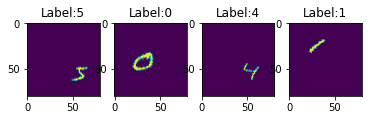

In [6]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [7]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [8]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):
    def __init__(self):
        super(STN_CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        self.localisation = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 20, kernel_size=5),
            nn.ReLU(),
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(23120, 20),
            nn.ReLU(),
            nn.Linear(20, 6)
        )
        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    def stn(self,x ):
        x_s = self.localisation(x)
        x_s = x_s.view(x_s.size(0), -1)
        theta = self.fc_loc(x_s)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x


    def forward(self, x):
        x = self.stn(x)
        x = self.avgpool(x)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)

        return out


STEP 3: CREATE MODEL CLASS (STN_CNN)


In [9]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localisation.0.weight 	 torch.Size([20, 1, 5, 5])
localisation.0.bias 	 torch.Size([20])
localisation.3.weight 	 torch.Size([20, 20, 5, 5])
localisation.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [10]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [11]:
print('STEP 6: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

# Model to GPU
model.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        #######
        img, label = img.to(device0), label.to(device0)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        #########
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
                            
    #Test
    model.eval()
    #############
    # Calculate Accuracy         
    correct = 0
    total = 0
    loss = 0
    # Iterate through test dataset
    for image, label in test_loader:
        image = image.to(device0)
        label = label.to(device0)

        output = model(image)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        loss += criterion(output, label)

        if torch.cuda.is_available():
            correct += (predicted.cpu() == label.cpu()).sum()
        else:
            correct += (predicted == label).sum()

    accuracy = 100 * correct.item() / total
    
    print('\nTest set accuracy:  [{}/{} ({:.0f}%)'.format(correct,test_size,correct/total))

    #############
    print('\n////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.300766  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.741838  

Test set accuracy:  [7865/10000 (1%)

////Epoch elapsed time: 7.819763422012329////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.721316  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.277541  

Test set accuracy:  [9239/10000 (1%)

////Epoch elapsed time: 7.707855939865112////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.326564  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.250478  

Test set accuracy:  [9445/10000 (1%)

////Epoch elapsed time: 7.594207286834717////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.209076  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.192681  

Test set accuracy:  [9539/10000 (1%)

////Epoch elapsed time: 7.923022747039795////

Train Epoch: 4 [0/60000 (0%) / Learni

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [12]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [13]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  99.16866987179488


In [14]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [15]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        x = self.model.stn(x)
        return x
    
    def visualize(self, img):
        transformed_img = self.forward_stn(img)
        
        original_imgs = reprocess_image(v_utils.make_grid(img, nrow=4))
        transformed_imgs = reprocess_image(v_utils.make_grid(transformed_img, nrow=4))
        
        f, arr = plt.subplots(1,2)
        arr[0].imshow(original_imgs)
        arr[0].set_title("Original images")
        
        arr[1].imshow(transformed_imgs)
        arr[1].set_title("Transformed images")
        
  

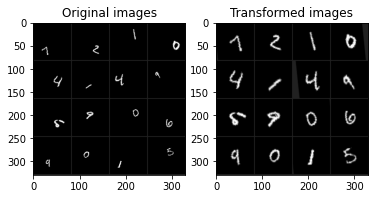

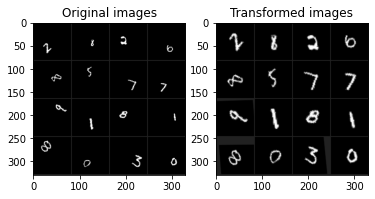

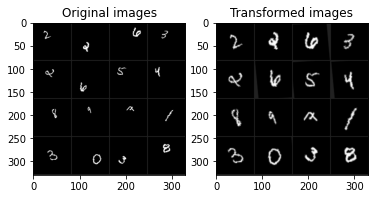

In [16]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [17]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.avgpool = nn.AvgPool2d(2, stride=2)

    self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=9),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=7),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(1600, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.avgpool(x)
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    out = self.classifier(x)

    return out


In [18]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.0.weight 	 torch.Size([32, 1, 9, 9])
cnn.0.bias 	 torch.Size([32])
cnn.3.weight 	 torch.Size([64, 32, 7, 7])
cnn.3.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [19]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [20]:
print('STEP 6: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

model_nostn.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        #######
        img, label = img.to(device0), label.to(device0)

        optimizer.zero_grad()
        output = model_nostn(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        #########
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
                            
    #Test
    model_nostn.eval()
    #############
    correct = 0
    total = 0
    loss = 0
    for image, label in test_loader:
        image = image.to(device0)
        label = label.to(device0)

        output = model_nostn(image)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        loss += criterion(output, label)

        if torch.cuda.is_available():
            correct += (predicted.cpu() == label.cpu()).sum()
        else:
            correct += (predicted == label).sum()

    accuracy = 100 * correct.item() / total
    
    print('\nTest set accuracy:  [{}/{} ({:.0f}%)'.format(correct,test_size,correct/total))

    #############
    print('\n////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.305004  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:1.277630  

Test set accuracy:  [6439/10000 (1%)

////Epoch elapsed time: 7.320088624954224////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:1.125779  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.913232  

Test set accuracy:  [7661/10000 (1%)

////Epoch elapsed time: 7.223963260650635////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.721942  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.649901  

Test set accuracy:  [8231/10000 (1%)

////Epoch elapsed time: 7.209192276000977////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.583258  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.402123  

Test set accuracy:  [8623/10000 (1%)

////Epoch elapsed time: 7.1698150634765625////

Train Epoch: 4 [0/60000 (0%) / Learn

#### Best accuracy of the model without ST module


In [21]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  97.36578525641026


ST module이 있는 CNN model과 ST module이 없는 model을 deformation된 이미지로 학습하였다. 
이때,ST module이 있는 model(STN)이 더 좋은 결과를 보여주었고, 그 차이를  Best accuracy로 확인할 수 있다.
두 모델의 best accuracy에서 유의미한 차이를 보여주었고, 기존의 CNN모델이 image deformation에 취약한 것을 실험적으로 알 수 있었다.

Spatial Transformer를 통과한 이미지와 통과하지 못한 이미지를 Visualization을 통해 확인하였다.
Visualization의 결과는 육안으로 보았을때, Spatial Transformer가 훨씬 더 알아보기 쉬웠다.
컴퓨터 비전에서 Neural network는 흔히 사람의 눈과 비교될 수 있는데, model의 결과와 육안으로 확인해서 구분하는 결과가 동일한 결과를 쫓는 것이 신기하였다.

또한, Visualization을 통해 transformation 전후 이미지를 확인하고, 딥러닝을 통한 model이 사람의 눈을 뛰어 넘을 수 있다는 것을 실험적으로 확인할 수 있어서 딥러닝의 의의를 한 번 더 생각해 볼 수 있었다.


### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>